In [16]:
import qutip as qt
from qutip import Bloch, QobjEvo, basis, sesolve, sigmay, sigmaz
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy.constants import h, e

# Operadores de Pauli en el qubit k

def SX(N : int, k : int) -> qt.Qobj:
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = qt.sigmax()
    return qt.tensor(L)

def SY(N : int, k : int) -> qt.Qobj:
    """Create a sigma_Y operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N
    L[k] = qt.sigmay()
    return qt.tensor(L)

def SZ(N : int, k : int) -> qt.Qobj:
    """Create a sigma_Z operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N
    L[k] = qt.sigmaz()
    return qt.tensor(L)


from qutip import create, destroy

def Sm(N : int, k : int) -> qt.Qobj:
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = destroy(2)
    return qt.tensor(L)

def Sp(N : int, k : int) -> qt.Qobj:
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = create(2)
    return qt.tensor(L)

print(create(2))

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]


# Hamiltonianos:

## 1) Hamiltoniando de Heisenberg:

$$
\hat{H} = -J \sum \limits_{j=0}^{N-1} \sigma_j \sigma_{j+1} - h \sum \limits_{j= 0}^{N-1} \sigma_j
$$

and $\sigma_N=\sigma_0$

In [5]:

"""
def H_Heisenberg_v1(n, arg, arg2): 
    H = 0 #Creamos el Hamiltoniano, con un offset en la energía 
   
    g = 1
    J = arg2
    
    H = H + np.sum([g*SZ(n,i)+ J*(SX(n,i)*SX(n,i+1)+SY(n,i)*SY(n,i+1))+arg*SZ(n,i)*SZ(n,i+1) if i != n-1 
                    g*SZ(n,i) + J*(SX(n,i)*SX(n,0)+SY(n,i)*SY(n,0))+arg*SZ(n,i)*SZ(n,0) else
                      for i in range(n)])
    
    return H
"""


def H_Heisenberg_v2(n, Jz, Jxy, g=1): 
    H = sum(
        g * SZ(n, i) +
        Jxy * (SX(n, i) @ SX(n, (i+1) % n) + SY(n, i) @ SY(n, (i+1) % n)) +
        Jz * SZ(n, i) @ SZ(n, (i+1) % n)
        for i in range(n)
    )
    return H



def H_Heisenberg_v3(n: int, Jz: float, Jxy: float, g: float = 1) -> qt.Qobj: 
    """Construct the Heisenberg Hamiltonian with periodic boundary conditions.

    H = g ∑ Sz_i + Jxy ∑ (Sx_i Sx_{i+1} + Sy_i Sy_{i+1}) + Jz ∑ Sz_i Sz_{i+1}

    Args:
        n (int): Number of qubits (sites).
        Jz (float): Coupling constant for Sz-Sz interaction.
        Jxy (float): Coupling constant for Sx-Sx and Sy-Sy interactions.
        g (float, optional): Strength of the local field in the Sz direction. Defaults to 1.

    Returns:
        qt.Qobj: The Hamiltonian as a QuTiP quantum object.
    """
    
    H = sum(
        g * SZ(n, i) +
        Jxy * (SX(n, i) * SX(n, (i + 1) % n) + SY(n, i) * SY(n, (i + 1) % n)) +
        Jz * SZ(n, i) * SZ(n, (i + 1) % n)
        for i in range(n)
    )

    return H




# Sumamos los términos g_ij sigmaz_i sigmaz_j


def H_Transversal_Ising(n, h_local, J_bilocal):
    
    H = 0  # Inicializamos el Hamiltoniano

    #Terminos del bulk    
    for i in range(n-1):
        H += h_local * SZ(n, i) - J_bilocal * SX(n, i) * SX(n, i + 1)

    #cond de Borde
    H += h_local * SZ(n, n-1) - J_bilocal * SX(n, n-1) * SX(n, 0)

    return H
        
    


def concurrence(rho):
    sy = qt.sigmay()
    rho_star = rho.conj()
    R = rho * (qt.tensor(sy, sy)) * rho_star * (qt.tensor(sy, sy))
    eigenvalues = R.eigenenergies()
    #eigenvalues = np.sqrt(R.eigenenergies())
    eigenvalues.sort()  # for increase order
    eigenvalues = np.abs(eigenvalues)
    #max_eigenvalue = eigenvalues[-1] - eigenvalues[-2] - eigenvalues[-3] - eigenvalues[-4]
    max_eigenvalue = np.sqrt(eigenvalues[-1]) - np.sqrt(eigenvalues[-2]) - np.sqrt(eigenvalues[-3]) - np.sqrt(eigenvalues[-4])
    return max(0, max_eigenvalue)

In [6]:
## "CLASES"
N = 4
s0 = qt.basis(2, 0)
s1 = qt.basis(2, 1)

#ESTADOS DE CADA CLASE DE ENTRELAZAMIENTO

#ESTADOS DE CADA CLASE DE ENTRELAZAMIENTO
psi_C1 = qt.tensor(s0,s0,s0,s0)
psi_C3 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s0,s1,s0))
psi_C9 = 1/2*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s1,s0) + qt.tensor(s1,s1,s1,s1) )
# psi_C11 = 1/np.sqrt(3)*(qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s0))
psi_C11=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C15 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s1,s1,s0))
#psi_C19 = 1/2*(qt.tensor(s1,s0,s0,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s0,s1,s0)+ qt.tensor(s0,s0,s0,s1))
psi_C19=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C22=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s1,s1,s0)).unit()
psi_C26 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s1,s1,s1))
psi_C28 = (1 / np.sqrt(5)) * (qt.tensor(s0, s0, s0, s0) +    qt.tensor(s0, s0, s1, s1) +    qt.tensor(s0, s1, s1, s0) +    qt.tensor(s1, s0, s0, s1) +    qt.tensor(s1, s1, s0, s0)) #REVISAR
psi_C31 = (1 / np.sqrt(12)) * (qt.tensor(s0, s0, s0, s0)- qt.tensor(s0, s0, s0, s1) - qt.tensor(s0, s0, s1, s0)    - qt.tensor(s0, s1, s0, s0)    + qt.tensor(s0, s1, s0, s1)    + qt.tensor(s0, s1, s1, s1)    - qt.tensor(s1, s0, s0, s0)    + qt.tensor(s1, s0, s1, s0)    + qt.tensor(s1, s0, s1, s1)   + qt.tensor(s1, s1, s0, s1)    + qt.tensor(s1, s1, s1, s0)    + qt.tensor(s1, s1, s1, s1))
c = 2
psi_C33 = (qt.tensor(s0, s0, s0, s0)+ c * qt.tensor(s0, s0, s1, s1)- (1 + c) * qt.tensor(s0, s1, s0, s1)- (1 + c) * qt.tensor(s1, s0, s1, s0)+ c * qt.tensor(s1, s1, s0, s0)+ qt.tensor(s1, s1, s1, s1)).unit()
psi_C36 = (qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s0,s1)).unit()
psi_C39 = (qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s1,s0)).unit()
psi_C43=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s1,s0)).unit()
psi_C48=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s1)).unit()
psi_C50=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C57=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C60=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit()
psi_C62=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C65=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s1)+qt.tensor(s1,s1,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit()
psi_C67=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s0,s1,s0)-qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s1,s0,s1)-qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)+qt.tensor(s1,s1,s1,s1)).unit()
psi_C68=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s1,s1,s1)).unit()
psi_C72=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
psi_C75=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s1,s1,s0)).unit() #REVISAR
psi_C80=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s1,s0)).unit()
psi_C82=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit() #REVISAR


## Invariantes

In [7]:
def CalculoInvariantes(state_vector):


    #  Callculo de los inariantes polinomiales
    x = state_vector.full().flatten() #vector data
    h1 = x[-1] *x[0] - x[1]* x[-2] - x[2] *x[-3] + x[3]* x[-4] -  x[4] *x[-5] + x[5] *x[-6] + x[6] *x[-7] - x[7] *x[-8]
    h2 = np.linalg.det(np.array([
        [x[0],x[4],x[8],x[12]],
        [x[1],x[5],x[9],x[13]],
        [x[2],x[6],x[10],x[14]],
        [x[3],x[7],x[11],x[15]]
    ]))

    h3 = np.linalg.det(np.array([
        [x[0], x[8], x[2], x[10]],
        [x[1], x[9], x[3], x[11]],
        [x[4], x[12], x[6], x[14]],
        [x[5], x[13], x[7], x[15]]
    ] ))
    h4 = np.linalg.det(np.array([
        [x[0] * x[3] - x[1] * x[2], x[3] * x[4] - x[2] * x[5] - x[1] * x[6] + x[0] * x[7], -x[5] * x[6] + x[4] * x[7]],
        [x[3] * x[8] - x[2] * x[9] - x[1] * x[10] + x[0] * x[11], x[7] * x[8] - x[6] * x[9] - x[5] * x[10] + x[4] * x[11] + x[3] * x[12] - x[2] * x[13] - x[1] * x[14] + x[0] * x[15],
            x[7] * x[12] - x[6] * x[13] - x[5] * x[14] + x[4] * x[15]],
        [ -x[9] * x[10] + x[8] * x[11], x[11] * x[12] - x[10] * x[13] - x[9] * x[14] + x[8] * x[15], -x[13] * x[14] + x[12] * x[15]
        ]
    ]))

    h1 = 0 if abs(h1) < 1e-15 else h1
    h2 = 0 if abs(h2) < 1e-15 else h2
    h3 = 0 if abs(h3) < 1e-15 else h3
    h4 = 0 if abs(h4) < 1e-15 else h4

    #  calcular los invariantes de entrelazamiento
    permutations = [[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

    Cab = concurrence(state_vector.ptrace([0,1]))
    Cac = concurrence(state_vector.ptrace([0,2]))
    Cad = concurrence(state_vector.ptrace([0,3]))
    Cbc = concurrence(state_vector.ptrace([1,2]))
    Cbd = concurrence(state_vector.ptrace([1,3]))
    Ccd = concurrence(state_vector.ptrace([2,3]))

    epsilon = 1e-6
    Cgm = min(np.real([(2 - 2 * (1 if abs((state_vector.ptrace(i) * state_vector.ptrace(i)).tr() - 1) < epsilon else (state_vector.ptrace(i) * state_vector.ptrace(i)).tr())) ** 0.5 for i in permutations]))

    #Cgm = min(np.real([(2 - 2 * (state_vector.ptrace(i) * state_vector.ptrace(i)).tr()) ** 0.5 for i in permutations]))



    return [h1.real, h2.real, h3.real, h4.real, Cab.real, Cac.real, Cad.real, Cbc.real, Cbd.real, Ccd.real, Cgm.real]




def identificar_clase(invariantes):
    clases = {
        'C1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C3': [0, 0, 0, 0, 0, '!=0', 0, 0, 0, 0, 0],
        'C9': ['!=0', '!=0', 0, 0, 0, '!=0', 0, 0, '!=0', 0, 0],
        'C11': [0, 0, 0, 0, '!=0', '!=0', 0, '!=0', 0, 0, 0],
        'C15': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C19': [0, 0, 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C22': [0, 0, 0, 0, 0, 0, 0, 0, '!=0', 0, '!=0'],
        'C26': ['!=0', 0, 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C28': ['!=0','!=0', 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C31': ['!=0', '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0'],
        'C33': ['!=0', '!=0', '!=0', '!=0', 0, '!=0', '!=0', '!=0', '!=0', 0, '!=0'],
        'C36': [0, 0, 0, 0, 0, 0, '!=0', 0, '!=0', 0, '!=0'],
        'C39': ['!=0', 0, 0, 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C43': ['!=0', '!=0', 0, 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C48': [0, '!=0', 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C50': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C57': ['!=0', 0, 0, 0, '!=0', '!=0', 0, 0,'!=0', '!=0', '!=0'],
        'C60': ['!=0', 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C62': [0, '!=0', 0, 0, '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0'],
        'C65': ['!=0', '!=0', 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C67': ['!=0', '!=0', '!=0', 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C68': ['!=0', 0, 0, 0, '!=0', '!=0', 0, '!=0', 0, 0, '!=0'],
        'C72': [0, 0, 0, '!=0', 0, 0, 0, 0, 0, 0,'!=0'],
        'C75': [0, '!=0', 0, 0, 0, '!=0', '!=0', 0, 0, '!=0', '!=0'],
        'C80': [0, '!=0', 0, '!=0', 0, '!=0', 0, 0, 0, 0, '!=0'],
        'C82': ['!=0', '!=0', '!=0', '!=0', '!=0','!=0', 0, 0, '!=0', '!=0', '!=0']
    }


    error = 1e-16


    for clase, condiciones in clases.items():
        cumple = True
        for i, condicion in enumerate(condiciones):
            if condicion == 0 and abs(invariantes[i]) > error:
                cumple = False
                break
            if condicion == '!=0' and abs(invariantes[i]) <= error:
                cumple = False
                break
        if cumple:
            return f'El estado pertenece a {clase}'

    return 'El estado no pertenece a ninguna clase conocida'



In [8]:
Hf = H_Transversal_Ising(4,1,1)
Ef = Hf.eigenstates()
GS = Ef[1][0]
GS

Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[ 1.08386376e-01]
 [ 0.00000000e+00]
 [-2.22044605e-16]
 [ 2.50000000e-01]
 [ 0.00000000e+00]
 [ 1.91341716e-01]
 [ 2.50000000e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.50000000e-01]
 [ 1.91341716e-01]
 [ 0.00000000e+00]
 [ 2.50000000e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 8.15493157e-01]]

In [9]:
psi = psi_C65
inv = CalculoInvariantes(psi)
print(identificar_clase(inv))

El estado pertenece a C65


In [10]:
def vector_clase(invariantes):
    clases = {
        'C1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C3': [0, 0, 0, 0, 0, '!=0', 0, 0, 0, 0, 0],
        'C9': ['!=0', '!=0', 0, 0, 0, '!=0', 0, 0, '!=0', 0, 0],
        'C11': [0, 0, 0, 0, '!=0', '!=0', 0, '!=0', 0, 0, 0],
        'C15': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'C19': [0, 0, 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C22': [0, 0, 0, 0, 0, 0, 0, 0, '!=0', 0, '!=0'],
        'C26': ['!=0', 0, 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C28': ['!=0','!=0', 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C31': ['!=0', '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0'],
        'C33': ['!=0', '!=0', '!=0', '!=0', 0, '!=0', '!=0', '!=0', '!=0', 0, '!=0'],
        'C36': [0, 0, 0, 0, 0, 0, '!=0', 0, '!=0', 0, '!=0'],
        'C39': ['!=0', 0, 0, 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C43': ['!=0', '!=0', 0, 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C48': [0, '!=0', 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C50': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '!=0'],
        'C57': ['!=0', 0, 0, 0, '!=0', '!=0', 0, 0,'!=0', '!=0', '!=0'],
        'C60': ['!=0', 0, 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C62': [0, '!=0', 0, 0, '!=0', 0, '!=0', '!=0', 0, '!=0', '!=0'],
        'C65': ['!=0', '!=0', 0, '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0', '!=0'],
        'C67': ['!=0', '!=0', '!=0', 0, 0, '!=0', 0, 0, '!=0', 0, '!=0'],
        'C68': ['!=0', 0, 0, 0, '!=0', '!=0', 0, '!=0', 0, 0, '!=0'],
        'C72': [0, 0, 0, '!=0', 0, 0, 0, 0, 0, 0,'!=0'],
        'C75': [0, '!=0', 0, 0, 0, '!=0', '!=0', 0, 0, '!=0', '!=0'],
        'C80': [0, '!=0', 0, '!=0', 0, '!=0', 0, 0, 0, 0, '!=0'],
        'C82': ['!=0', '!=0', '!=0', '!=0', '!=0','!=0', 0, 0, '!=0', '!=0', '!=0']
    }

    error = 1e-16
    resultado = [0] * 27

    for idx, (clase, condiciones) in enumerate(clases.items()):
        cumple = True
        for i, condicion in enumerate(condiciones):
            if condicion == 0 and abs(invariantes[i]) > error:
                cumple = False
                break
            if condicion == '!=0' and abs(invariantes[i]) <= error:
                cumple = False
                break
        if cumple:
            resultado[idx] = 1
            break

    return resultado


In [11]:
### 1000 cases of random coefficients

A = np.empty((27, 0))
for i in range(0,1000):
    rand1 = np.random.uniform(-1, 1)
    rand2 = np.random.uniform(-1, 1)
    Hf = H_Transversal_Ising(4,rand1,rand1)
    Ef = Hf.eigenstates()
    GS = Ef[1][0]
    inv = CalculoInvariantes(GS)
    a = vector_clase(inv)
    A = np.column_stack((A, a))





In [12]:
def obtener_sumas(Matriz):
    etiquetas = [
        'C1', 'C3', 'C9', 'C11', 'C15', 'C19', 'C22', 'C26', 'C28', 'C31',
        'C33', 'C36', 'C39', 'C43', 'C48', 'C50', 'C57', 'C60', 'C62', 'C65',
        'C67', 'C68', 'C72', 'C75', 'C80', 'C82'
    ]
    sumas = Matriz.sum(axis=1)  # Sumar los elementos de cada fila
    return dict(zip(etiquetas, sumas))  # Crear un diccionario con etiquetas y sus sumas

results = obtener_sumas(A)

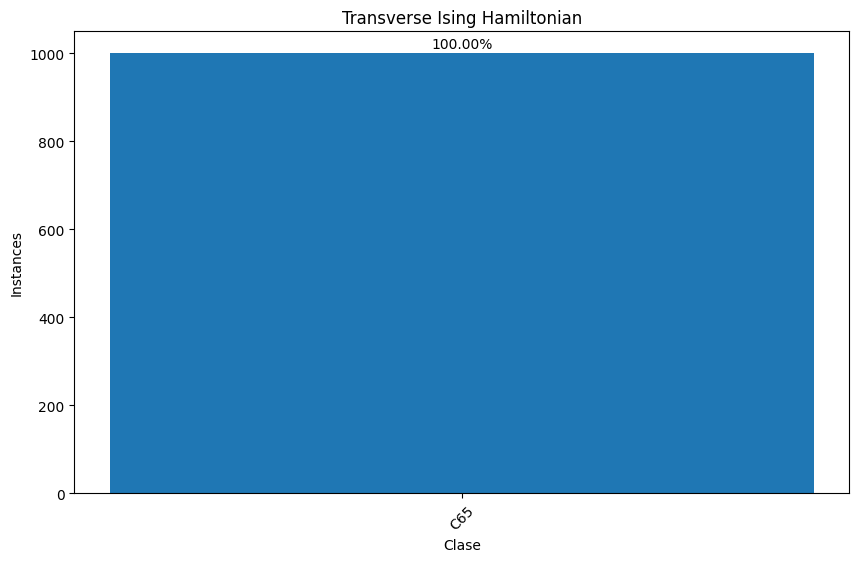

In [13]:
resultados_filtrados = {k: v for k, v in results.items() if v != 0}

total_instancias = sum(resultados_filtrados.values())

# Crear el histograma
plt.figure(figsize=(10, 6))
bars = plt.bar(resultados_filtrados.keys(), resultados_filtrados.values())

# Añadir porcentajes sobre cada barra
for bar in bars:
    height = bar.get_height()
    porcentaje = (height / total_instancias) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{porcentaje:.2f}%', ha='center', va='bottom')

# Etiquetas y título
plt.xlabel('Clase')
plt.ylabel('Instances')
plt.title('Transverse Ising Hamiltonian')
plt.xticks(rotation=45)
plt.show()

## VQE

In [14]:
# Operador U local en el qubit k
def U_qubit(N, k, params):
   
    theta, phi, lambd = params  # Extrae los 3 parámetros para U

    # Define la matriz de U
    U = np.array([
        [np.cos(theta/2), -np.exp(1j * lambd) * np.sin(theta/2)],
        [np.exp(1j * phi) * np.sin(theta/2), np.exp(1j * (phi + lambd)) * np.cos(theta/2)]
    ])

    # Convierte a Qobj de Qutip
    U_qobj = qt.Qobj(U)

    # Construye el operador tensorial en el sistema de N qubits
    L = [qt.qeye(2)] * N  # Lista con Identidades en todos los sitios
    L[k] = U_qobj  # Sustituye en el qubit k
    return qt.tensor(L)


# Número de qubits
N = 4  

# Vector de parámetros (12 elementos en total: 3 por cada qubit)
params_vec = [np.pi/4, np.pi/3, np.pi/6,  # Qubit 0
              np.pi/2, np.pi/4, np.pi/8,  # Qubit 1
              np.pi/3, np.pi/6, np.pi/2,  # Qubit 2
              np.pi/8, np.pi/3, np.pi/4]  # Qubit 3

# Generar los operadores U para cada qubit
U_0 = U_qubit(N, 0, params_vec[0:3])  # U en el qubit 0
U_1 = U_qubit(N, 1, params_vec[3:6])  # U en el qubit 1
U_2 = U_qubit(N, 2, params_vec[6:9])  # U en el qubit 2
U_3 = U_qubit(N, 3, params_vec[9:12]) # U en el qubit 3

# Comprobamos los operadores generados
print(U_0)

# Función de coste para el VQE simulado


def Cost(params, *args):
    global cost_values
    U_0 = U_qubit(N, 0, params[0:3])  # U en el qubit 0
    U_1 = U_qubit(N, 1, params[3:6])  # U en el qubit 1
    U_2 = U_qubit(N, 2, params[6:9])  # U en el qubit 2
    U_3 = U_qubit(N, 3, params[9:12])
    psi_e = args[0]
    H = args[1]

    Psi = U_3*U_2*U_1*U_0*psi_e
    
    cost = qt.expect(H, Psi)
    cost_values.append(cost)
    return cost

    

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.23879533e-01+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
  -3.31413574e-01-0.19134172j  0.00000000e+00-0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          9.23879533e-01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00-0.j         -3.31413574e-01-0.19134172j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   9.2

In [15]:
import numpy as np
from scipy.optimize import minimize

# Definir los límites de los parámetros manualmente para COBYLA
constraints = []
for i in range(12):
    lower_bound = 0
    upper_bound = np.pi if i % 3 == 0 else 2 * np.pi  # Cada tercer parámetro tiene límite en pi
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] - lower_bound})  # x[i] >= lower_bound
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: upper_bound - x[i]})  # x[i] <= upper_bound

# Inicialización de los parámetros aleatorios dentro de los límites
x = [np.random.uniform(0, np.pi) if i % 3 == 0 else np.random.uniform(0, 2*np.pi) for i in range(12)]

psi_ansatz = psi_C65
Hf = H_Transversal_Ising(4,1,1)
# Argumentos de la función de costo
args1 = (psi_ansatz, Hf) #(Estado de la clase de entrelazamiento, Hamiltoniano de la molecula)

# Minimización usando COBYLA
cost_values = []
VQE = minimize(Cost, x, args=args1, method='COBYLA', constraints=constraints, options={'maxiter': 20000, 'disp': True, 'tol': 1e-79})

print(VQE)


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.798672150410338
       x: [-1.466e-19  5.516e+00  3.914e+00  2.621e+00  7.450e-02
            6.549e-02  2.383e+00  6.230e+00  6.244e+00  5.207e-01
            3.216e+00  6.218e+00]
    nfev: 20000
   maxcv: 1.4660127383526654e-19

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =20000   F =-2.798672E+00    MAXCV = 1.466013E-19
   X =-1.466013E-19   5.516049E+00   3.914463E+00   2.620835E+00   7.450259E-02
       6.549264E-02   2.382638E+00   6.229727E+00   6.244162E+00   5.207197E-01
       3.215701E+00   6.218112E+00


# Fermi-Hubbard Model:

brief intro:

$$
\hat{H} = -t \sum \limits_{\langle i, j \rangle, \sigma} \bigg (  \hat{c}_i^{\dagger \sigma}  \hat{c}_j ^\sigma + \text{h.c.} \bigg ) + U \sum \limits_i \hat{n}_{i \uparrow} \hat{n}_{i \downarrow} - \mu \sum \limits_i \hat{n}_{i \uparrow} + \hat{n}_{i \downarrow}
$$

First Term: Kinetic or hopping energy, t: hopping amplitude = 1

Second Term: Potential energy: On-site term, U parameter of the coulomb interaction (self energy)

Third Term: Chemical potential (cahgne in energy due to change in the number of particles). If conservation of particles $\to \mu = 0$ 

$n_{k \uparrow} = a_{k \uparrow}^{\dagger} a_{k \uparrow}$ and $n_{k \downarrow} = a_{k \downarrow}^{\dagger} a_{k \downarrow}$

In [ ]:
from math import pi

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel

from qiskit_nature.second_q.mappers import JordanWignerMapper


def fermi_hubbard_hammiltonian(t : float, u : float) -> qt.Qobj:
    num_nodes = 2
    boundary_condition = BoundaryCondition.OPEN
    line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

    v = 0.0  # the onsite potential

    fhm = FermiHubbardModel(
        line_lattice.uniform_parameters(
            uniform_interaction=t,
            uniform_onsite_potential=v,
        ),
        onsite_interaction=u,
    )

    fermionic_ham = fhm.second_q_op().simplify()
    mapper = JordanWignerMapper()

    pauli_op_fh_hamiltonian = mapper.map(fermionic_ham)
    matrix_representation = pauli_op_fh_hamiltonian.to_matrix()
    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])

    return qt_hamiltonian_op




In [ ]:
def class_output(t, u) -> int:
    
    fermi_hubbard_ham = fermi_hubbard_hammiltonian(t, u)

    energy_spectra_fermi_hubbard = fermi_hubbard_ham.eigenstates()
    ground_state = energy_spectra_fermi_hubbard[1][0]

    invariants_fermi_hubbard = CalculoInvariantes(ground_state)
    family_index = vector_clase(invariants_fermi_hubbard)

    if 1 not in family_index:
        return -1
    else:
        return family_index.index(1)



t_values = np.linspace(-10, 10, 100)
u_values = np.linspace(-10, 10, 100)

grid = np.zeros((len(t_values), len(u_values)))




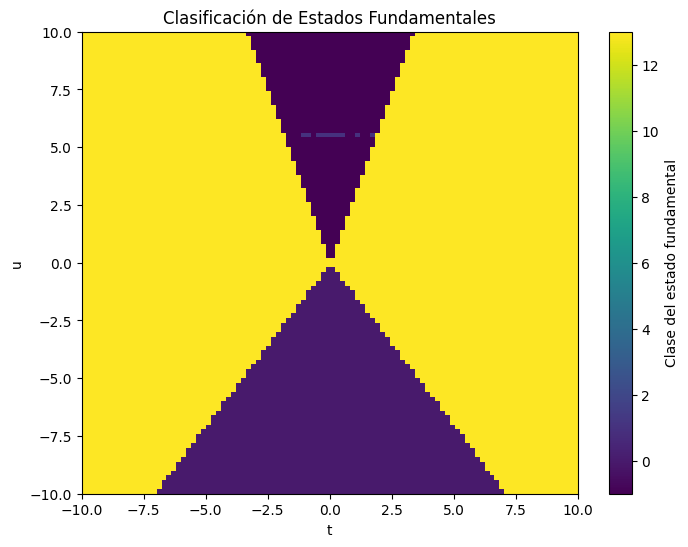

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Definir los valores de t y u
t_values = np.linspace(-10, 10, 100)
u_values = np.linspace(-10, 10, 100)

# Crear la grid para almacenar los resultados
grid = np.zeros((len(u_values), len(t_values)))

# Vectorizamos la clasificación
for i, u in enumerate(u_values):
    for j, t in enumerate(t_values):
        grid[i, j] = class_output(t, u)

# Graficamos la matriz con un mapa de colores
plt.figure(figsize=(8, 6))
plt.imshow(grid, origin="lower", extent=[-10, 10, -10, 10], aspect="auto", cmap="viridis")
plt.colorbar(label="Clase del estado fundamental")
plt.xlabel("t")
plt.ylabel("u")
plt.title("Clasificación de Estados Fundamentales")
plt.show()


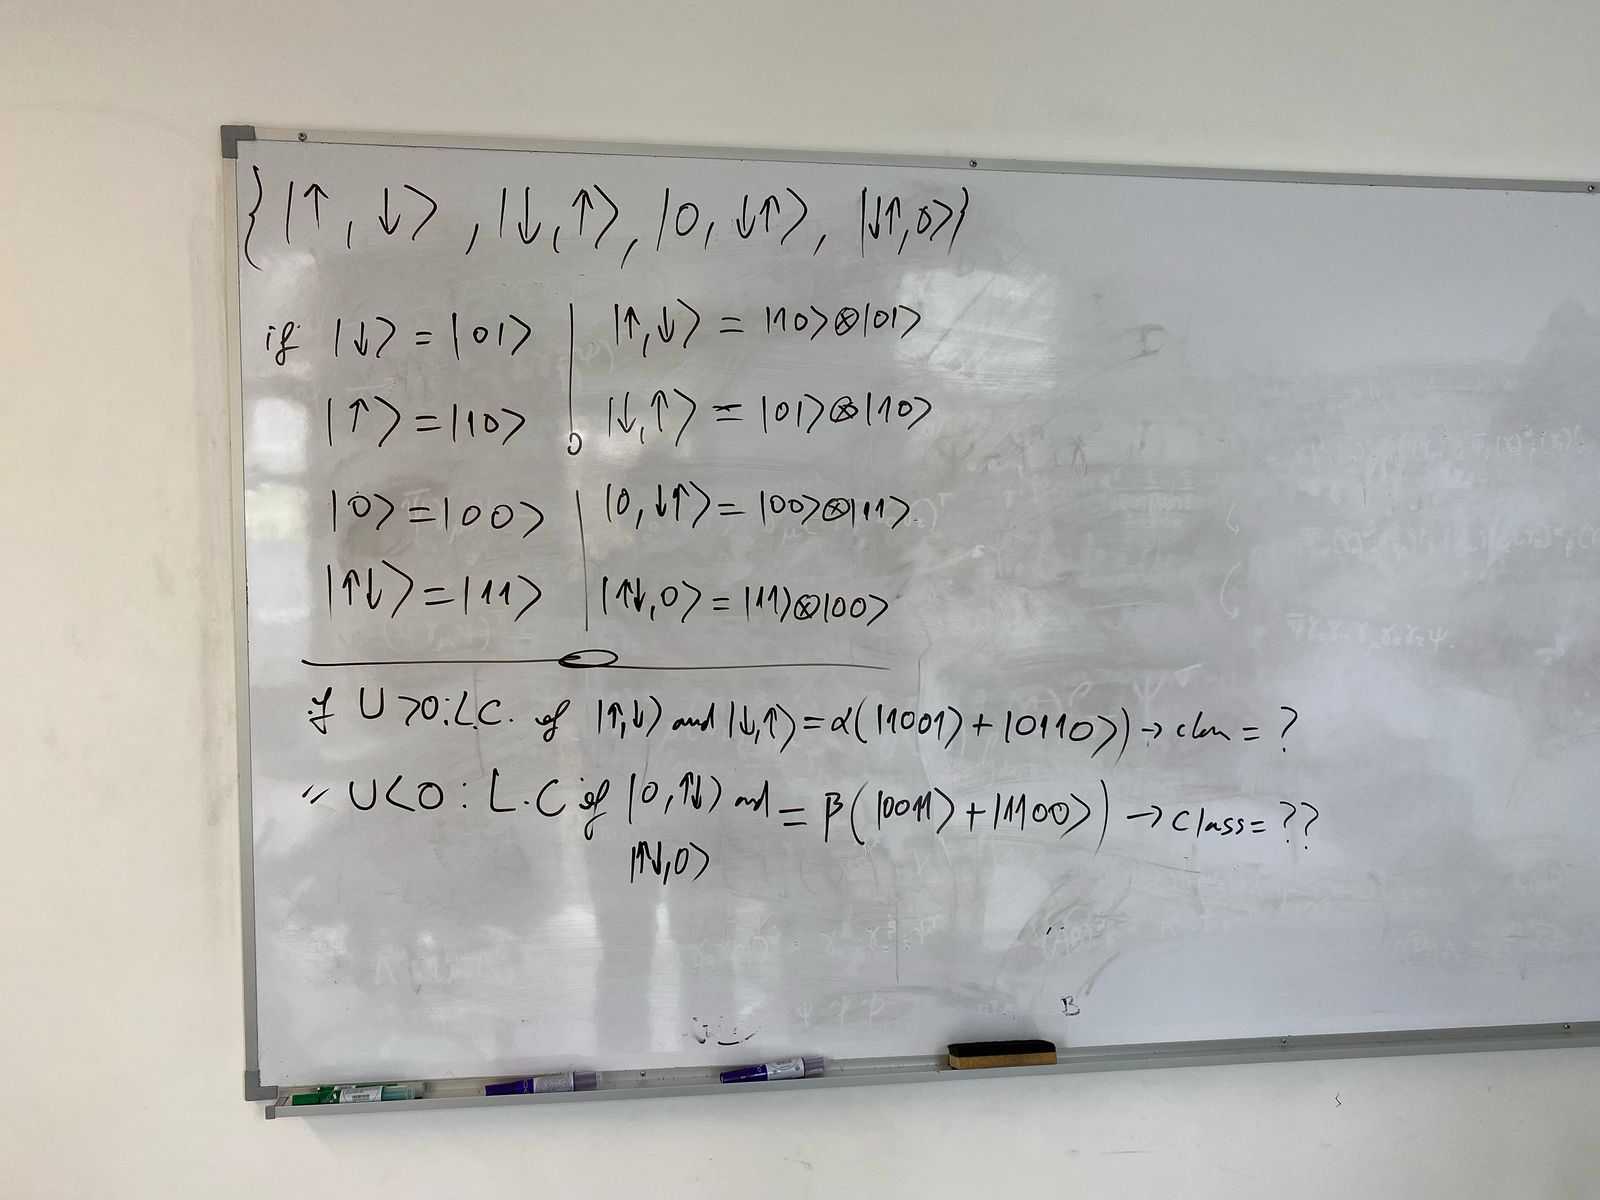

In [ ]:
### 1000 cases of random coefficients

A = np.empty((27, 0))
for i in range(0,1000):
    rand1 = np.random.uniform(-1, 1)
    rand2 = np.random.uniform(-1, 1)
    Hf = H_Transversal_Ising(4,rand1,rand1)
    Ef = Hf.eigenstates()
    GS = Ef[1][0]
    inv = CalculoInvariantes(GS)
    a = vector_clase(inv)
    A = np.column_stack((A, a))


results = obtener_sumas(A)

In [ ]:
resultados_filtrados = {k: v for k, v in results.items() if v != 0}

total_instancias = sum(resultados_filtrados.values())

# Crear el histograma
plt.figure(figsize=(10, 6))
bars = plt.bar(resultados_filtrados.keys(), resultados_filtrados.values())

# Añadir porcentajes sobre cada barra
for bar in bars:
    height = bar.get_height()
    porcentaje = (height / total_instancias) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{porcentaje:.2f}%', ha='center', va='bottom')

# Etiquetas y título
plt.xlabel('Clase')
plt.ylabel('Instances')
plt.title('Transverse Ising Hamiltonian')
plt.xticks(rotation=45)
plt.show()